<h1>Algaeorithm V1</h1>
<p>The goal of this version is to count chlamydomonas cells from high definition pictures</p>

# Imports

In [1]:
!pip install pyheif
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline
import imutils
from skimage import io
from skimage.filters import try_all_threshold, threshold_otsu, threshold_local
from skimage.color import rgb2gray
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from google.colab import drive
import pyheif
from PIL import Image
from scipy import ndimage, stats
import math
import cv2

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Visualization

<h3>Define Visualization Functions</h3>

In [2]:
#Converts path to image array which can be used for processing or display
project_path = "gdrive/MyDrive/ISB_Ambassador_Project"
def path_to_image(image_path):
  try:
    img = io.imread(image_path)
  except ValueError:
    try:
      heif_file = pyheif.read(image_path)
      img = np.asarray(Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride))
    except ValueError:
      print(image_path + ": Invalid file format. Please provide a jpg, jpeg, png, or heic file")
      return np.zeros((1, 1, 1))
  except FileNotFoundError:
    print(image_path + ": Please enter a valid path")
    return np.zeros((1, 1, 1))
  return img

In [3]:
#Get list of images used for this project
chlamy_files = !ls {project_path + "/Algaeorithm_V1/Clear_Chlamy_Pictures"}
chlamy_images = sorted(list(map(lambda x: project_path + "/Algaeorithm_V1/Clear_Chlamy_Pictures/" + x.strip(), np.asarray([chlamy_image.split("  ") for chlamy_image in chlamy_files]).ravel())))

In [4]:
#Converts path of folder to list of image arrays, each of which can be displayed or processed
def folder_path_to_images(images_folder):
  try:
    folder_list = !ls {images_folder}
  except FileNotFoundError:
    print("Invalid path")
    return False
  images = list(map(lambda x: path_to_image(images_folder + "/" + x.strip()), np.asarray([image_block.split("  ") for image_block in folder_list]).ravel()))
  images_length = len(images) - list(map(lambda x: x.any(), images)).count(np.zeros(1))
  return images, images_length

In [5]:
#Displays all images in given folder
def display_images(images_folder):
  if not folder_path_to_images(images_folder):
    return
  else:
    images, image_length = folder_path_to_images(images_folder)
  fig, axes = plt.subplots(1, image_length)
  idx = -1
  for image in images:
    if image.any():
      idx += 1
      axes[idx].imshow(image)
  fig.set_figwidth(35)
  fig.show()

In [6]:
#Show histogram by color of image given path
def plot_image_hist(image_path):
  img = path_to_image(image_path)
  if type(img) == bool:
    return
  colors = ["Red", "Green", "Blue"]
  fig, axes = plt.subplots(1, 4)
  axes[0].imshow(img)
  for i in range(1, 4):
    color = img[:, :, i-1]
    axes[i].hist(color.ravel(), bins=256)
    axes[i].set_title(colors[i-1])
  fig.set_figwidth(35)
  fig.show()

In [7]:
#Show histograms for all images in given folder
def plot_images_hist(images_folder):
  if not folder_path_to_images(images_folder):
    return
  images, image_length = folder_path_to_images(images_folder)
  fig, axes = plt.subplots(image_length, 4)
  idx = -1
  colors = ["Red", "Green", "Blue"]
  for image in images:
    if image.any():
      idx += 1
      axes[idx, 0].imshow(image)
      for i in range(1, 4):
        color = image[:, :, i-1]
        axes[idx, i].hist(color.ravel(), bins=256)
        axes[idx, i].set_title(colors[i-1])
  fig.set_figwidth(35)
  fig.set_figheight(5 * len(images))
  fig.show()

<h3>Visualize Images for Initial Version</h3>

<p>Histograms of the chlamy images made it apparent that there was the most variance in the blue color of the pixel, which would be helpful for thresholding later.</p>

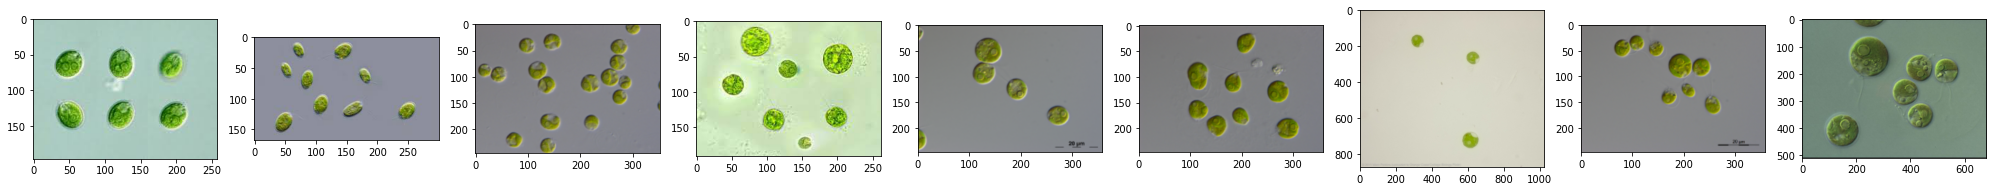

In [8]:
#Display pictures in folder
display_images(project_path + "/Algaeorithm_V1/Clear_Chlamy_Pictures")

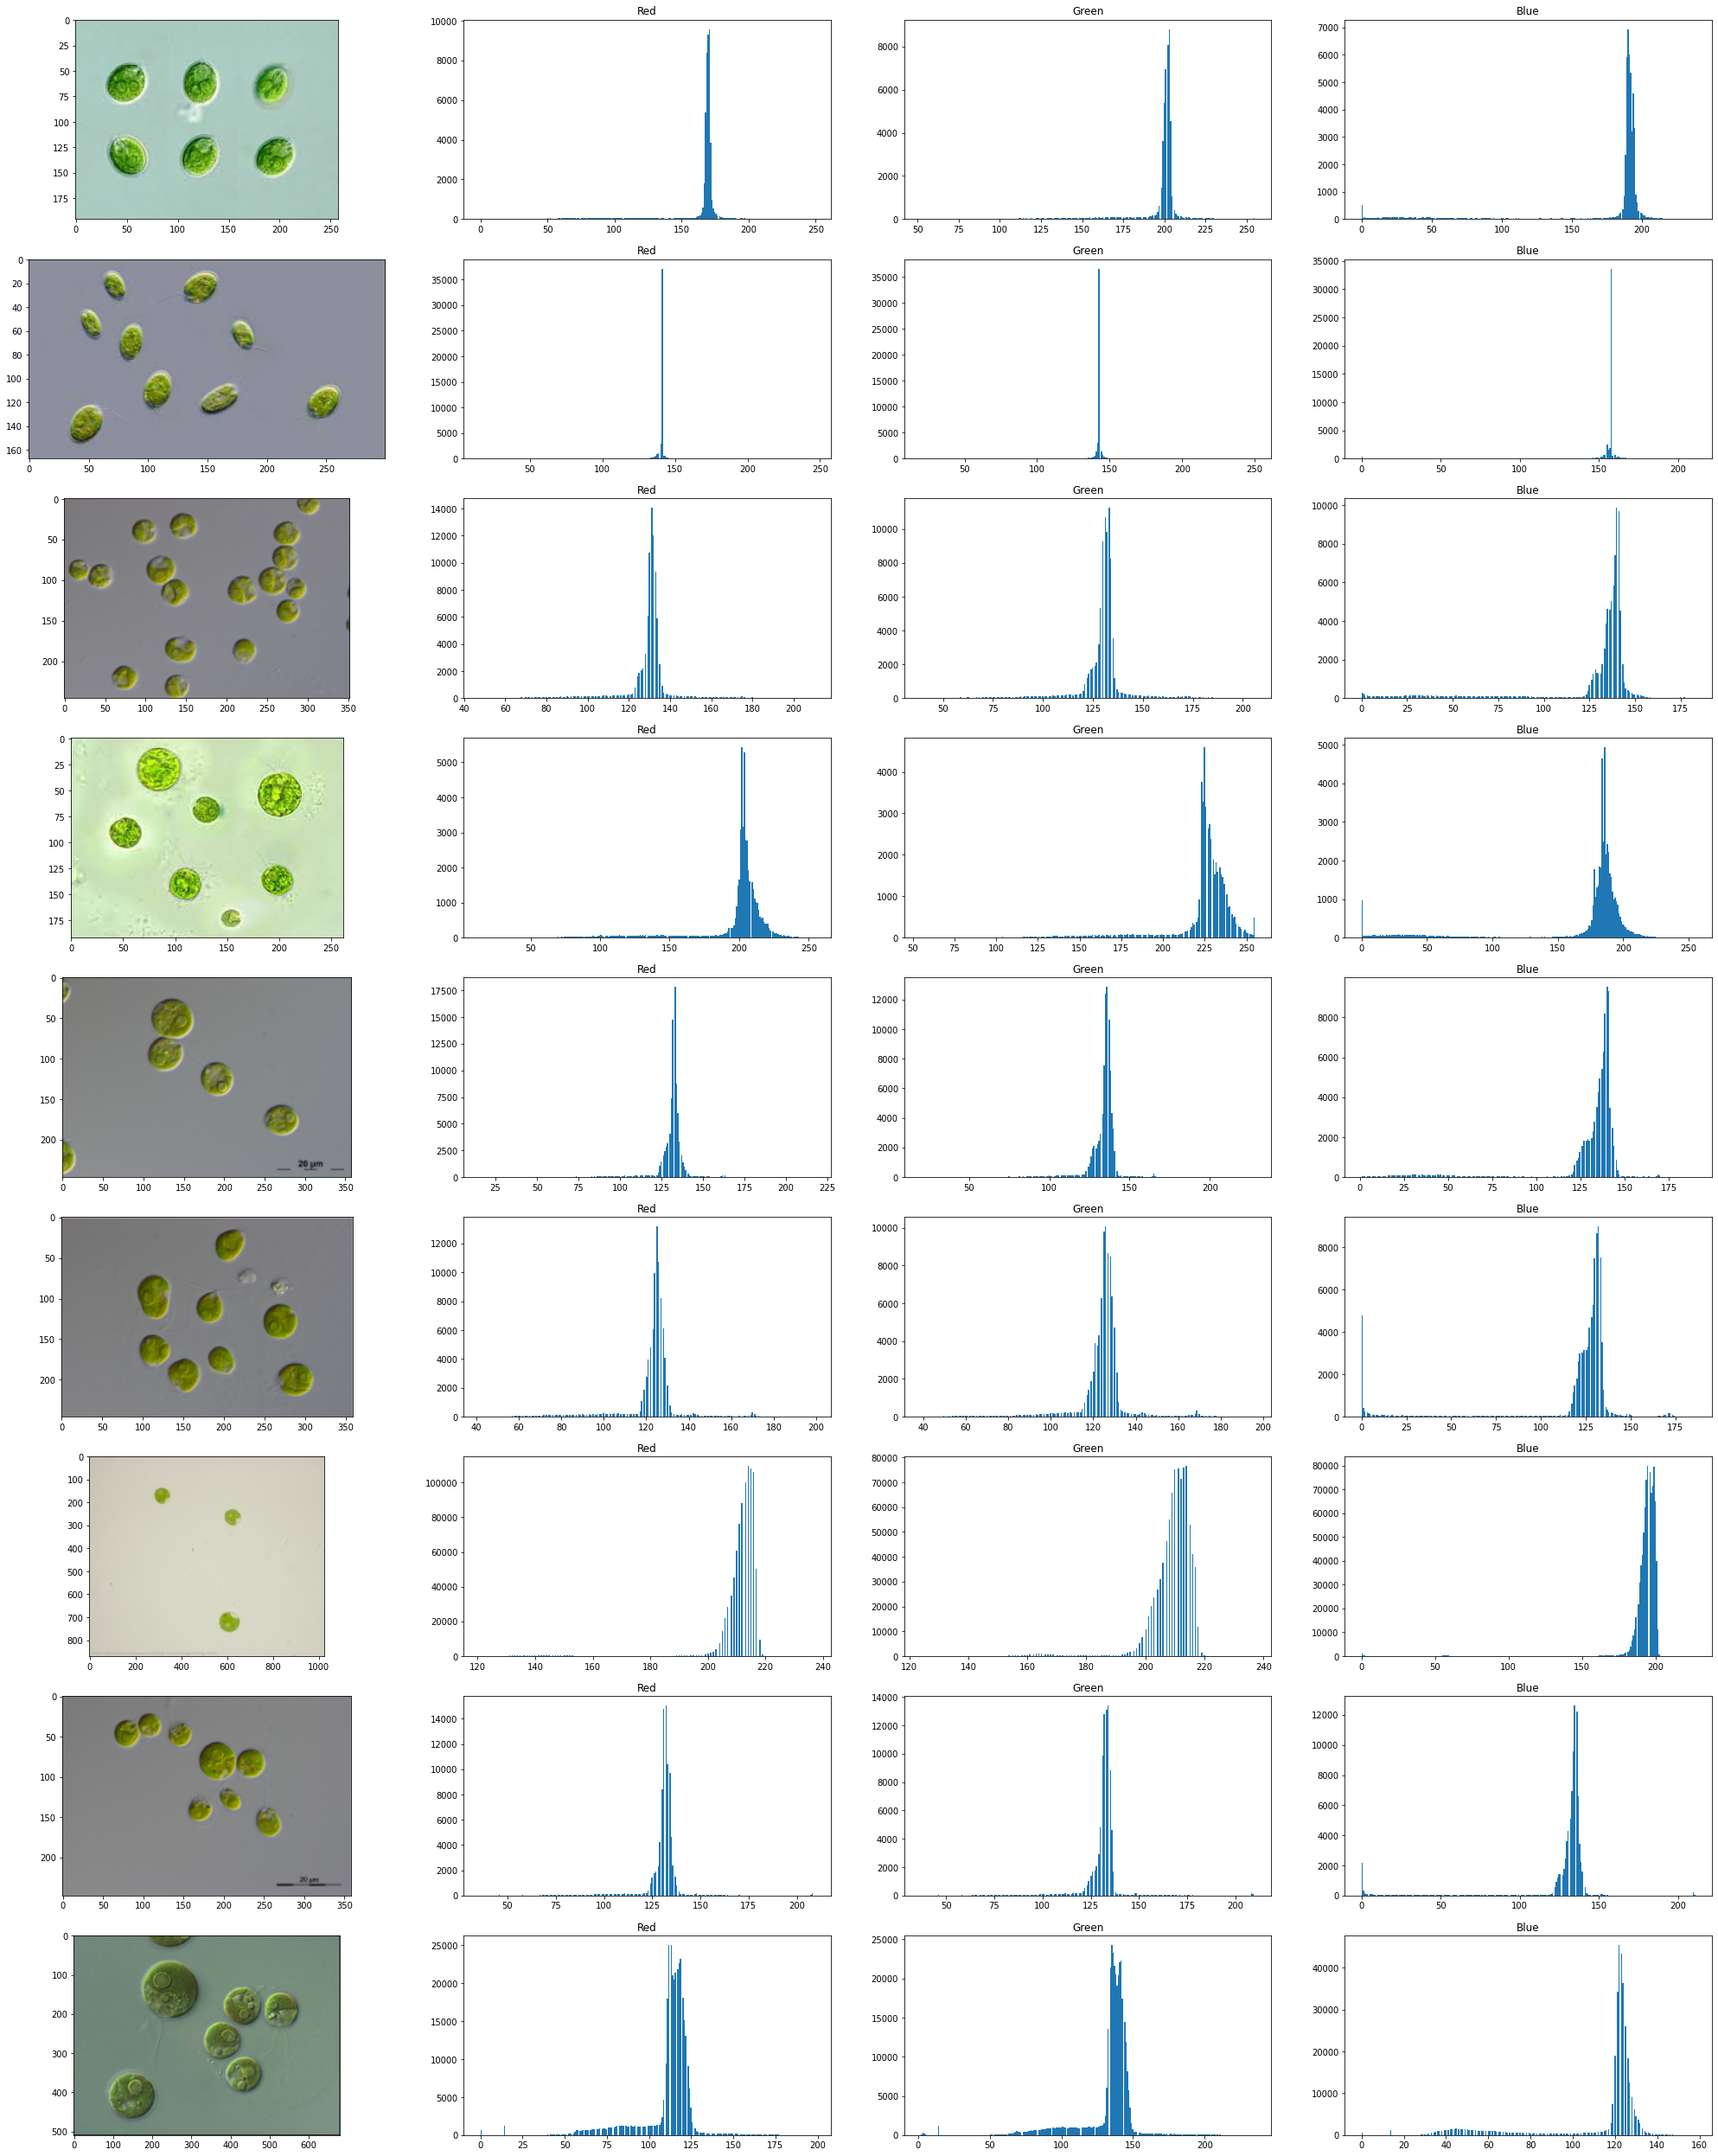

In [9]:
#Show histograms of pictures
plot_images_hist(project_path + "/Algaeorithm_V1/Clear_Chlamy_Pictures")

<h3>Thresholding Images</h3>

<p>As expected, skimage's "Threshold Otsu" function was optimal for images with a clear background, and their Threshold Local function was optimal for images without a clear background. Also, using only the blue channel of each image turned out to be more effective for thresholding than grayscale.</p>

In [10]:
#Function to figure out what kind of thresholding to use for filtering
def show_all_thresholds(index):
  image = path_to_image(chlamy_images[index])
  if not image.any():
    return
  if len(image.shape) > 2:
    image = image[:, :, 2]
  fig, axes = try_all_threshold(image)
  plt.show()

In [11]:
#Function to return a binary image given an image path and threshold function
def threshold_image(image_path, clear_background=True, block_size=35):
  image = path_to_image(image_path)
  if not image.any():
    return
  if len(image.shape) > 2:
    image = image[:, :, 2]
  if not clear_background:
    thresh = threshold_local(image, block_size)
  else:
    thresh = threshold_otsu(image)
  if np.mean(image) > threshold_otsu(image):
    binary = image < thresh
  else:
    binary = image < thresh
  return binary.astype(np.uint8) * 255

In [12]:
#Function to display thresholded image alongside original image
def show_threshold(image_path, clear_background=True, block_size=35):
  fig, axes = plt.subplots(1, 2)
  axes[0].imshow(path_to_image(image_path))
  axes[1].imshow(threshold_image(image_path, clear_background, block_size))
  fig.set_figwidth(20)
  plt.show()

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


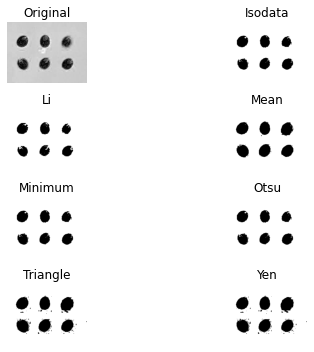

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


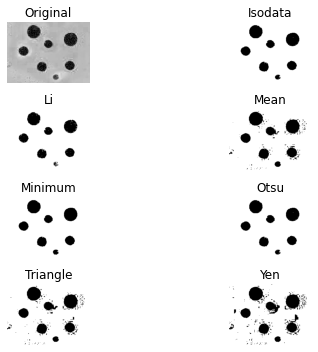

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


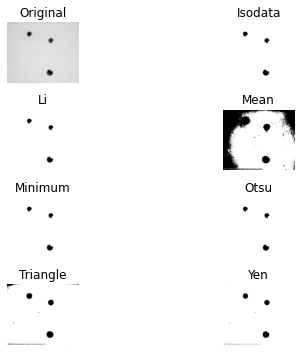

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


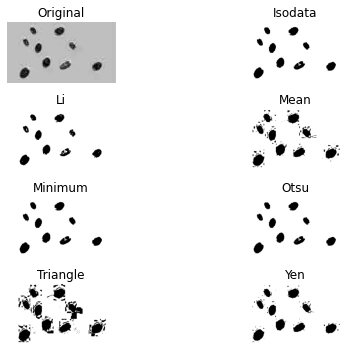

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


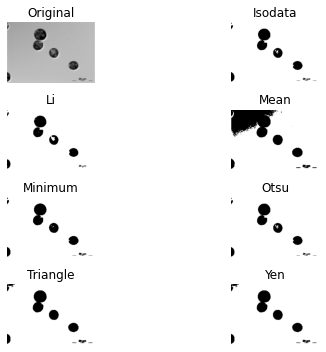

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


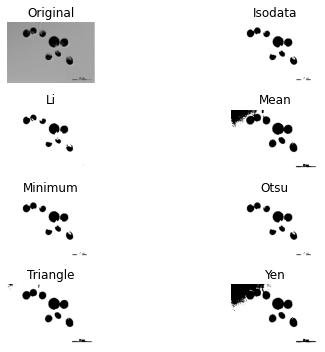

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


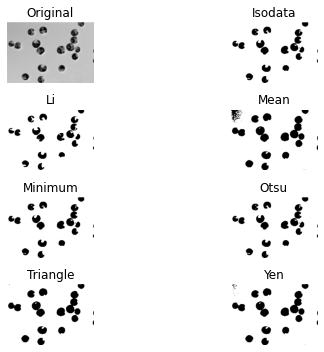

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


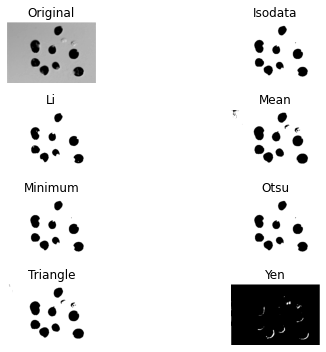

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


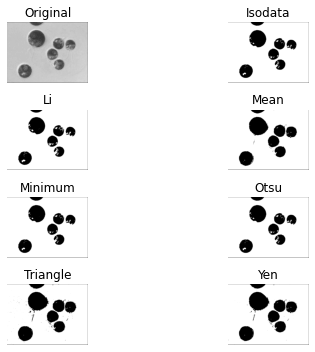

In [13]:
#Show thresholds for clear background images
for i in range(9):
  show_all_thresholds(i)

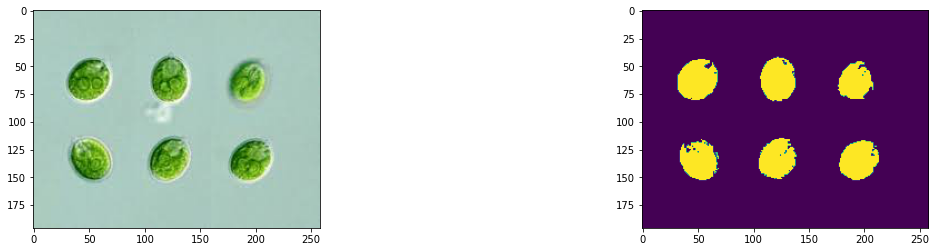

In [14]:
path = chlamy_images[0]
show_threshold(path, clear_background=True)

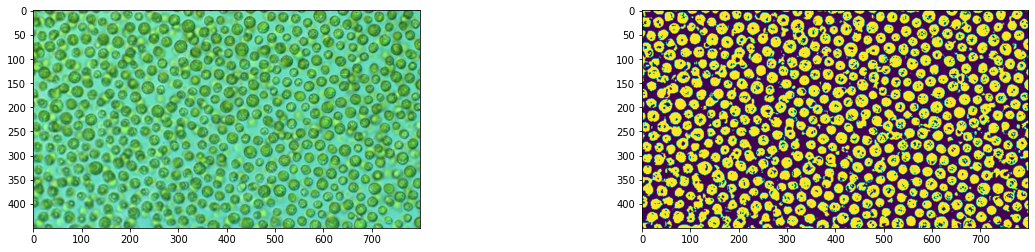

In [15]:
url = "https://media.sciencephoto.com/image/k0048546/800wm"
show_threshold(url, clear_background=False)

# Cell Counting

<p>There were three major factors to account for when counting the cells and finding outlines: overlap, outliers, and when the algorithm would find cells within cells. Currently, the functions do have optional parameters which increase the accuracy of the cell counting, and if these parameters aren't provided, the function makes a best guess based both off of the image itself and the default settings. The goal is for the function to eventually be able to calculate what these parameters should be automatically.</p>

In [16]:
#Functiton to convert image into list of contours/outlines, accounting for overlap and outliers
#code to find overlap adapted from https://www.pyimagesearch.com/2015/11/02/watershed-opencv/
def image_to_contours_list(image_path, clear_background=True, block_size=35, min_ratio=0.1, max_ratio=3, min_distance=10):
  image = path_to_image(image_path)
  gray_shape = rgb2gray(image).shape
  #Threshold the image, and fill holes in contours
  thresh = ndimage.morphology.binary_fill_holes(threshold_image(image_path, clear_background, block_size))
  #Find peaks and convert to labels
  D = ndimage.distance_transform_edt(thresh)
  localMax = peak_local_max(D, indices=False, min_distance=min_distance, labels=thresh)
  markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
  labels = watershed(-D, markers, mask=thresh)
  all_contours = []
  #Find contours in labels, and add largest contour to list of contours
  for label in np.unique(labels):
    if label == 0:
      continue
    mask = np.zeros(gray_shape, dtype="uint8")
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    all_contours.append(c)
  #Remove outliers in contour area
  contour_areas = list(map(cv2.contourArea, all_contours))
  all_contours = [contour for idx, contour in enumerate(all_contours) if abs(stats.zscore(contour_areas)[idx]) < 5]
  contour_areas = list(map(cv2.contourArea, all_contours))
  return [contour for contour in all_contours if min_ratio * np.mean(contour_areas) < cv2.contourArea(contour)]

In [17]:
#Function to count cells given image path as well as other optional paramaters
def count_cells(image_path, clear_background=True, block_size=35, min_ratio=0.1, max_ratio=3, min_distance=10, return_outlines=False):
  test_image = path_to_image(image_path)
  if not test_image.any():
    return -1
  #Calculate area once to get an idea of the area of each cell in pixels, then calculate again with new minimum distance which takes into account the new areas
  all_contours = image_to_contours_list(image_path, clear_background=clear_background, block_size=block_size, min_ratio=min_ratio, max_ratio=max_ratio, min_distance=min_distance)
  contour_areas = list(map(cv2.contourArea, all_contours))
  new_min_distance = round(math.sqrt(np.mean(contour_areas)) / 3)
  all_contours = image_to_contours_list(image_path, clear_background=clear_background, block_size=block_size, min_ratio=min_ratio, max_ratio=max_ratio, min_distance=new_min_distance)
  all_contours = sorted(all_contours, key=cv2.contourArea, reverse=True)
  i1 = 0
  coords = []
  #Remove outlines that are swallowed up by other outlines
  while i1 < len(all_contours):
    c1 = all_contours[i1]
    ((x1, y1), r1) = cv2.minEnclosingCircle(c1)
    coords.append(cv2.minEnclosingCircle(c1))
    i2 = 0
    while i2 < len(all_contours):
      c2 = all_contours[i2]
      if not np.array_equal(c1, c2):
        ((x2, y2), r2) = cv2.minEnclosingCircle(c2)
        if ((((x2 - x1 )**2) + ((y2-y1)**2) )**0.5) < r1:
          all_contours.pop(i2)
        else:
          i2 += 1
      else:
        i2 += 1
    i1 += 1
  if return_outlines:
    return all_contours, coords
  return len(all_contours)

In [18]:
#Function to display which cells algorithm found, either as circles covering each cell or each cell's outline
def display_outlines(url, circles=False, clear_background=True):
  outlines = count_cells(url, clear_background, return_outlines=True) 
  display_image = path_to_image(url)
  fig,axes = plt.subplots(1, 2)
  fig.suptitle("There are {} cells in {}.".format(len(outlines[0]), url))
  fig.set_size_inches(18.5, 5)
  axes[0].imshow(display_image)
  if circles:
    axes[1].set_aspect('equal')
    axes[1].imshow(display_image)
    for ((x1, y1), r1) in outlines[1]:
      circ = Circle((x1, y1), r1)
      axes[1].add_patch(circ)
    fig.show()
  else:
    cv2.drawContours(display_image, outlines[0], -1, (255, 0, 0), 2)
    axes[1].imshow(display_image)
    fig.show()

# Results

<p>Ultimately, this version is able to count and label chlamydomona cells with almost complete accuracy in images with well defined cells, and the accuracy deteriotates as the cells decrease in clarity.</p>

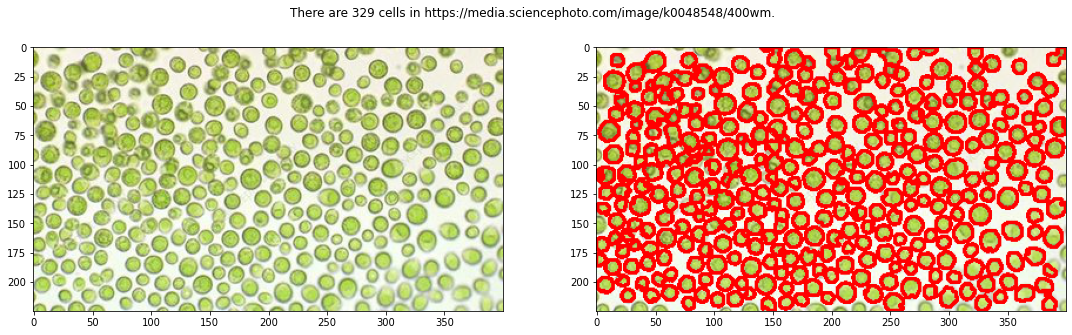

In [19]:
url = "https://media.sciencephoto.com/image/k0048548/400wm"
display_outlines(url, False, False)

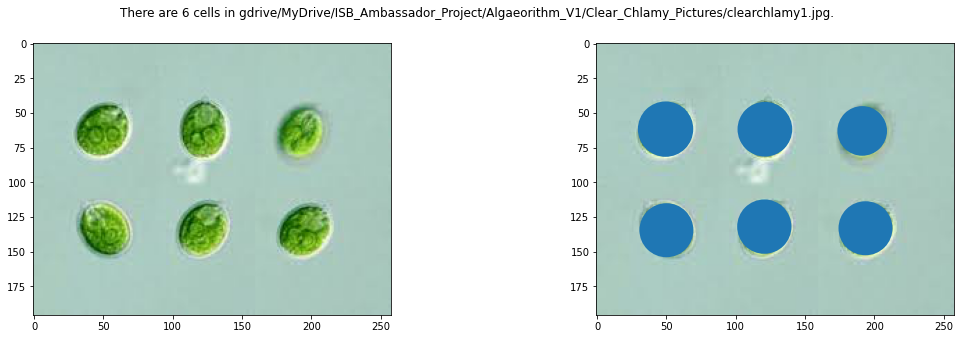

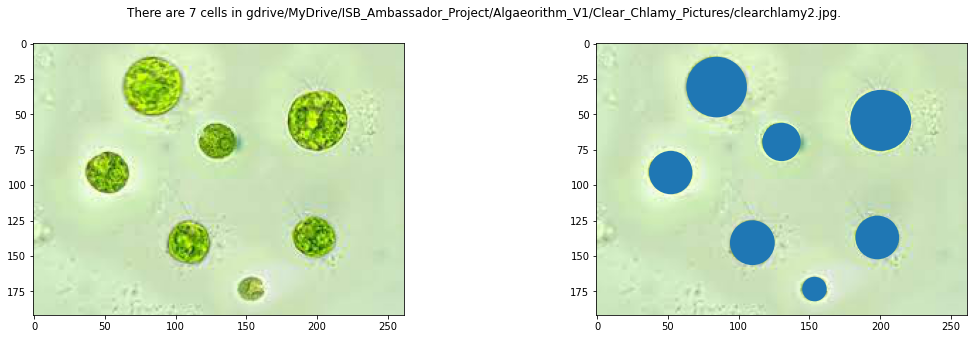

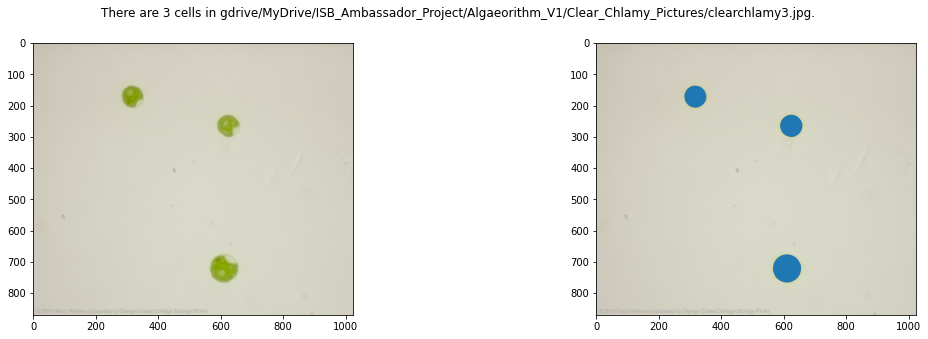

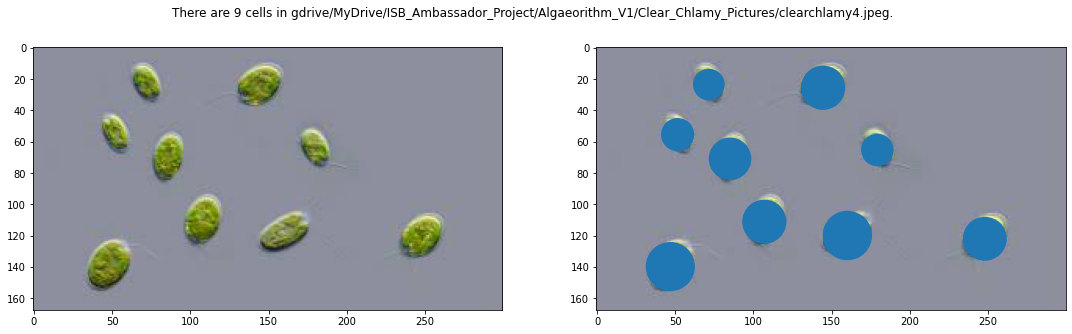

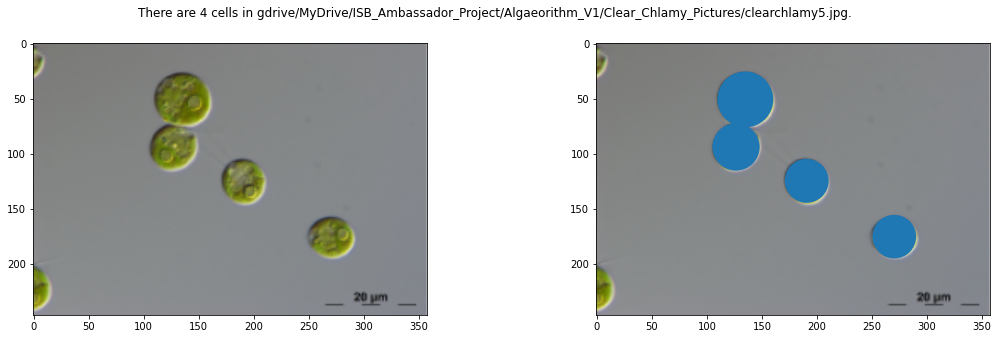

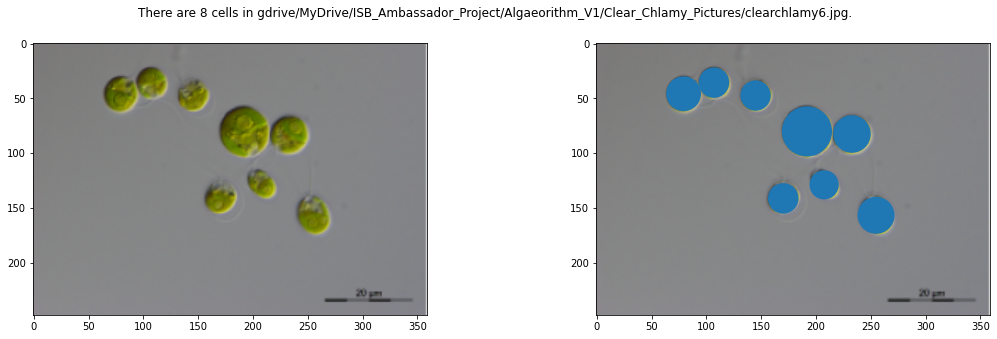

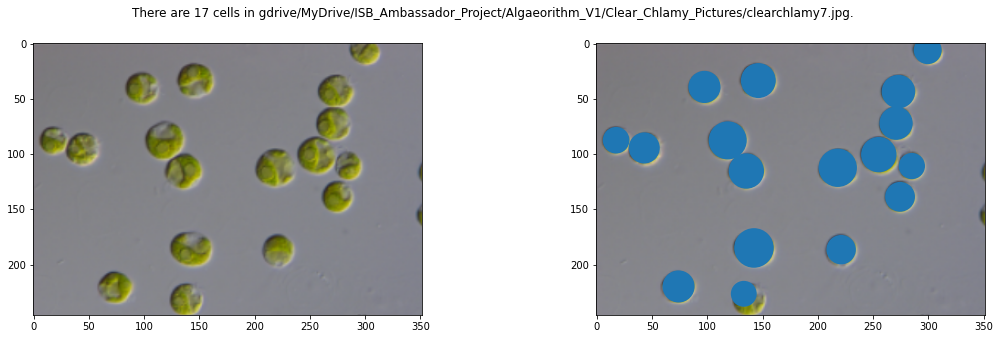

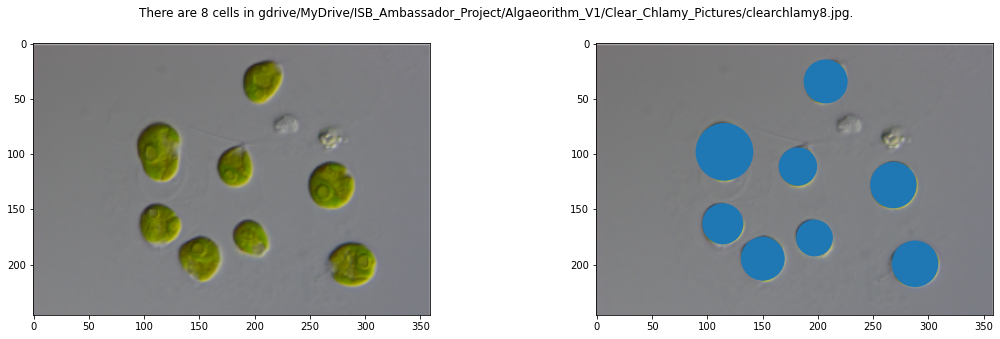

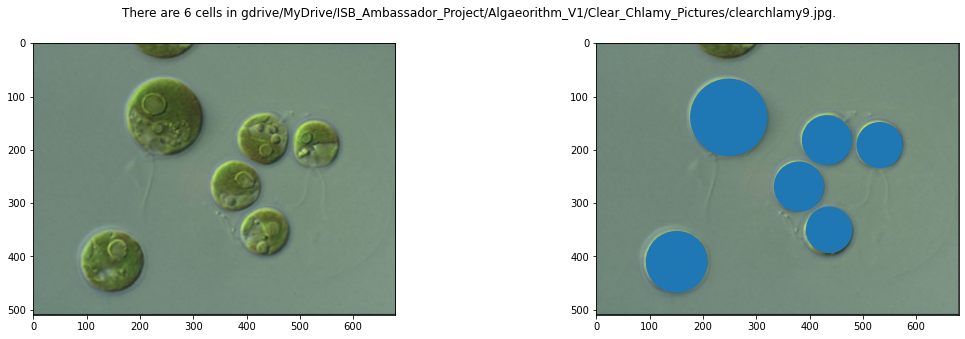

In [20]:
for chlamy_image in chlamy_images:
  display_outlines(chlamy_image, True)